In [1]:
import pandas as pd
import numpy as np
from ipyslickgrid import show_grid
from ipywidgets import VBox, IntSlider
from plotly.graph_objs import Bar
from plotly.graph_objs.layout import Annotation

from simple.chart import chartParallel, chartFigure, updateFigure, chartTrades
from simple.backtest import npBacktestMarket, getProfit, default_fee
from simple.pretty import pp
from simple.types import TPairTrade

pd.options.display.float_format = '{:,.1f}'.format
np.set_printoptions(suppress=True, linewidth=140, edgeitems=5, precision=4)

In [2]:
R = pd.read_parquet('result.parquet')
R.head(1)

,RMSE(t),Corr(t),Acc(t),RMSE(v),Corr(v),Acc(v),Trees,_PnL,PMean,PMax,PRatio,_Target,_Pred,_Features,_Gain,_Split
Horizon,,,,,,,,,,,,,,,,
1,1.6,50.7,80.0,2.4,35.3,75.6,250,"[-22114.890411886237, -19442.05641908431, -171...",10.4,20.1,26,"[1.203125, 4.0976562, -5.3496094, -1.3496094, ...","[-0.10745197, 0.21194641, -0.42626062, -0.0116...","[vA1 on Traded, vA2 on Traded, vA5 on Traded, ...","[41200.175132751465, 50624.78712463379, 305775...","[61, 31, 62, 82, 60, 40, 48, 90, 36, 24, 55, 9..."


In [3]:
# Parallel coordinates chart
r = R[[col for col in R.columns if col[0] != '_']]
chartParallel(r, inverse=['RMSE(t)', 'RMSE(v)', 'Horizon'])

FigureWidget({
    'data': [{'dimensions': [{'label': 'Horizon',
                              'range': [24, 1],
                              'values': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24])},
                             {'label': 'RMSE(t)',
                              'range': [10.712410797697741, 1.6493141994987952],
                              'values': array([ 1.6493,  2.4516,  3.154 ,  3.7626,  4.309 ,  4.8056,  5.2734,  5.7029,
                                                6.1167,  6.514 ,  6.9045,  7.2513,  7.6026,  7.9303,  8.2488,  8.565 ,
                                                8.8424,  9.147 ,  9.4186,  9.6866,  9.9559, 10.2132, 10.4743, 10.7124])},
                             {'label': 'Corr(t)',
                              'range': [19.619984494507325, 50.71676496443535],
                              'values': array([50.7168, 47.2609, 42.105 ,

In [4]:
T = np.load('bidask.npz')['T'].view(np.recarray)
T

rec.array([('2023-03-11T14:17:32.497000', 19949.0996, 19949.1992, 0), ('2023-03-11T14:17:32.598000', 19950.3008, 19950.4004, 0),
           ('2023-03-11T14:17:32.852000', 19954.4004, 19954.5   , 0), ('2023-03-11T14:17:32.947000', 19949.    , 19949.1992, 0),
           ('2023-03-11T14:17:33.053000', 19947.6992, 19947.8008, 0), ..., ('2023-04-04T23:58:58.294000', 28202.5   , 28202.5996, 0),
           ('2023-04-04T23:58:58.886000', 28200.5996, 28200.6992, 0), ('2023-04-04T23:58:59.092000', 28200.    , 28200.0996, 0),
           ('2023-04-04T23:58:59.487000', 28199.8008, 28199.9004, 0), ('2023-04-04T23:58:59.681000', 28199.3008, 28199.4004, 0)],
          dtype=[('DateTime', '<M8[us]'), ('Bid', '<f8'), ('Ask', '<f8'), ('Act', 'i1')])

In [5]:
# Profit table for all horizons and threshold
b = 26    # skip lower thresholds due high fees
E = R['_PnL'].apply(pd.Series).T
P = pd.concat([E.iloc[b::3], pd.DataFrame(R.PRatio).T, pd.DataFrame(R.PMean).T, pd.DataFrame(R.PMax).T])
display(pp(P, h_subset=(P.iloc[-4:].index, slice(None))))

Horizon,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
26,-81.7,-97.6,-119.2,-106.3,-102.6,-70.4,-86.2,-48.1,-50.4,-40.0,-30.3,-31.4,-37.3,-19.4,-21.5,-8.7,16.8,-1.6,-10.6,4.1,-10.0,15.1,-2.0,5.0
29,-77.9,-59.4,-54.2,-69.9,-59.5,-43.5,-42.7,-58.0,-38.7,-1.2,-10.8,-20.4,-1.8,22.0,10.5,5.4,19.0,20.1,2.9,9.1,13.2,9.7,22.6,-0.9
32,-58.9,-25.8,-18.4,-31.6,-48.4,-26.6,-14.2,-42.6,-16.5,-9.3,13.0,10.0,15.0,30.3,29.2,18.3,16.6,17.8,12.9,31.0,21.2,22.4,27.5,13.7
35,-68.7,-17.6,0.9,-4.3,-17.3,2.8,9.8,-8.5,36.7,19.5,30.9,27.1,31.7,51.6,33.0,19.6,30.0,32.3,19.4,34.4,18.8,30.1,23.0,9.0
38,-65.1,-20.4,-0.4,2.9,-15.2,4.8,16.8,27.8,44.4,60.9,28.0,42.3,52.1,45.3,35.4,31.1,22.2,25.5,23.7,41.5,19.7,11.4,15.9,12.5
41,-71.0,-3.0,-3.3,8.6,26.9,42.8,31.8,36.2,58.9,69.4,34.9,49.1,62.3,39.9,53.7,49.5,24.7,19.8,9.2,36.9,24.1,5.7,5.7,7.0
44,-55.3,-12.2,5.1,8.2,26.0,32.3,47.1,45.7,59.4,44.9,43.3,57.1,63.0,31.7,46.0,28.1,18.2,8.2,23.5,23.9,23.1,-3.6,20.4,6.7
47,-49.3,-16.1,15.8,11.7,37.0,47.4,53.8,43.0,62.0,32.9,38.4,51.8,50.4,29.1,43.8,31.8,24.0,16.7,34.5,13.1,38.7,5.3,20.1,14.6
50,-17.7,-0.7,16.0,19.4,36.9,43.9,62.3,36.0,58.4,16.5,38.9,40.8,45.8,32.5,33.2,18.5,23.5,13.4,32.5,1.8,35.2,20.1,20.2,12.2
53,-19.7,-5.2,9.5,18.1,47.2,49.4,57.7,44.5,46.2,26.4,34.9,38.1,42.0,28.9,27.2,16.9,38.4,11.5,26.1,-4.7,20.1,30.1,15.6,18.6


In [6]:
# Main chart
fig = chartFigure(rows=2, height=450,
                  Bid=dict(y=T['Bid'], color='green', opacity=0.1, shape='hv'),
                  Ask=dict(y=T['Ask'], color='red', opacity=0.1, shape='hv'),
                  Ideal=dict(color='gray', secondary_y=True, shape='hv'),
                  Profit=dict(color='blue', secondary_y=True, shape='hv'),
                  **chartTrades(np.empty(0, dtype=TPairTrade).view(np.recarray), use_time=False),
                  Pred=dict(row=2),
                  Target=dict(row=2, opacity=0.4))

fig.add_hline(0, line_color='gray', line_dash='dot', line_width=1)
fig.add_hline(0, line_color='gray', line_dash='dot', line_width=1);

In [7]:
# Profit barchart
fig2 = chartFigure(height=150)
fig2.update_layout(annotations=[Annotation(text='Profit', showarrow=True, arrowhead=3, ax=0, ay=-20)])
fig2.add_trace(Bar(x=np.arange(b, 100), y=R.at[18, '_PnL'][b:], marker_line_color='black', marker_color='green', opacity=0.7));

In [8]:
th = 64   # default threshold

def bar_click(trace, points, selector):
    global th
    for point in points.point_inds:
        th = int(trace['x'][point])
        update_figure_threshold()
        
fig2.data[0].on_click(bar_click)

In [9]:
# Event handlers for update visual controls while table scrolling
def update_annot(profit, text='Profit'):
    """Update annotation arrow that shows profit at current threshold value"""
    global th
    with fig2.batch_update():
        fig2.layout.annotations[0]['x'] = th
        fig2.layout.annotations[0]['y'] = profit if profit > 0 else 0
        fig2.layout.annotations[0]['text'] = text


def update_figure_threshold():
    """Update figure by specified threshold data"""
    global trades, th
    trades = npBacktestMarket(T, Pred, Thresholds[th])
    p = getProfit(trades)
    updateFigure(fig, 
                 Ideal=dict(y=p.MidPnL.cumsum(), x=p.Index),
                 Profit=dict(y=p.Profit.cumsum(), x=p.Index),
                 **chartTrades(trades, use_time=False),
                )
    profit = p.Profit.sum()/T.Bid[0]*100
    threshold = Thresholds[th]
    update_annot(profit, f'Profit={profit:,.0f}%   Trades={len(p)}   Threshold={threshold:,.5f}')
    with fig.batch_update():
        fig.layout['shapes'][0]['y0'] = threshold
        fig.layout['shapes'][0]['y1'] = threshold
        fig.layout['shapes'][1]['y0'] = -threshold
        fig.layout['shapes'][1]['y1'] = -threshold
    
    
def grid_changed(event, grid):
    """Redraw chart with selected horizon value"""

    changed = grid.get_changed_df()
    k = event['new'][0]
    horizon = changed.iloc[k].name
    
    fig2.data[0].y = R.at[horizon, '_PnL'][b:]
    
    global Pred, Thresholds
    Pred = R.at[horizon, '_Pred']
    Thresholds = np.linspace(0, np.percentile(np.abs(Pred), 99.98), 100)

    update_figure_threshold()
    updateFigure(fig, Pred=Pred, Target=R.at[horizon, '_Target'])

In [10]:
# Result grid
grid = show_grid(r, grid_options={'editable': False, 'forceFitColumns': True, 'multiSelect': False, 'rowHeight': 26, 'maxVisibleRows': 5})
grid.on('selection_changed', grid_changed)
grid.change_selection([7])

In [11]:
# Show all
VBox([fig, fig2, grid])

    'data': [{'line': {'color': 'green', 'shape': 'hv'},
              …

In [12]:
# error histogram calculation
delta = R.loc[10]['_Pred'] - R.loc[10]['_Target']
delta

array([-3.01  ,  0.1825,  4.6546,  1.1114, -2.0997, ..., -1.8062, -0.7401, -1.0107, -2.1808, -1.4591], dtype=float32)

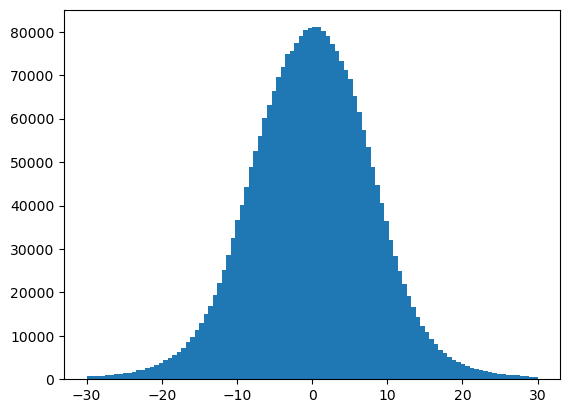

In [13]:
import matplotlib.pyplot as plt

plt.hist(delta, bins=100, range=(-30, 30));